# Introduction to problem
In this case study you will help an organization which funds projects submitted by high
school teachers across US. The name of the organization is Donor’s Choose.
DonorsChoose.org is an online charity that makes it easy to help students in need through
school donations. At any time, thousands of teachers in K-12 schools propose projects
requesting materials to enhance the education of their students. When a project reaches its
funding goal, they ship the materials to the school.

In this exercise the goal is to identify projects that are exceptionally exciting to the business,
at the time of posting. While all projects on the site fulfill some kind of need, certain projects
have a quality above and beyond what is typical. By identifying and recommending such
projects early, Donor’s Choose will improve funding outcomes, better the user experience,
and help more students receive the materials they need to learn.
In order to complete this project, you will need to use a broad range of skills in text
processing, feature engineering and predictive modelling.

## Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import re
from nltk import *
lemma = WordNetLemmatizer()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
warnings.filterwarnings('ignore')

In [2]:
stop_words = stopwords.words('english')

## Loading Data

In [136]:
projects=pd.read_csv('data_projects.csv')
outcomes=pd.read_csv('data_outcomes.csv')
essays=pd.read_csv('data_essays.csv')

In [137]:
temp=pd.merge(projects,essays)
df_merged=pd.merge(temp,outcomes,how='left')

In [138]:
AR=df_merged.describe(include='all').T
missing=df_merged.isna().sum()
miss_perc=round(df_merged.isna().sum()*100/len(df_merged),2)
AR.drop(['25%','50%','75%'],inplace=True,axis=1)

In [139]:
AR.insert(loc=1,column='missing',value=missing)
AR.insert(loc=2,column='miss_perc',value=miss_perc)
AR['Q5']=df_merged.quantile(0.05)
AR['Q10']=df_merged.quantile(0.10)
AR['Q25']=df_merged.quantile(0.25)
AR['Q50']=df_merged.quantile(0.50)
AR['Q75']=df_merged.quantile(0.75)
AR['Q85']=df_merged.quantile(0.85)
AR['Q95']=df_merged.quantile(0.95)
AR['Q99']=df_merged.quantile(0.99)

## Making Audit Report

In [140]:
AR.to_csv('Audit_Report.csv',index=True)

## Calculating Missing Values

In [4]:
def missing_values(df):
    #Total missing values
    missing_vals = df.isnull().sum()
    
    #percentage missing values
    missing_values_per = 100 * df.isnull().sum()/len(df)
    
    #make a dataframe
    missing_valu_table = pd.concat([missing_vals,missing_values_per],axis=1)
    
    #rename the columns
    miss_vals_table_remaned = missing_valu_table.rename(columns={0:'Missing Values',1:'Percentage of missing'})
    
    #sort by percentage
    miss_vals_table_remaned = miss_vals_table_remaned[
        miss_vals_table_remaned.iloc[:,1] != 0].sort_values('Percentage of missing',ascending=False).round(2)
    
    return miss_vals_table_remaned

In [5]:
missing_values(projects)

,Missing Values,Percentage of missing
secondary_focus_subject,207893,31.30
secondary_focus_area,207893,31.30
school_metro,81908,12.33
school_ncesid,42736,6.44
fulfillment_labor_materials,35082,5.28
school_district,948,0.14
students_reached,146,0.02
resource_type,45,0.01
primary_focus_subject,39,0.01
primary_focus_area,39,0.01


In [6]:
missing_values(outcomes)

,Missing Values,Percentage of missing
great_messages_proportion,179839,29.04
at_least_1_teacher_referred_donor,94398,15.24
at_least_1_green_donation,94398,15.24
three_or_more_non_teacher_referred_donors,94398,15.24
one_non_teacher_referred_donor_giving_100_plus,94398,15.24
donation_from_thoughtful_donor,94398,15.24
teacher_referred_count,94398,15.24
non_teacher_referred_count,94398,15.24


In [7]:
missing_values(essays)

,Missing Values,Percentage of missing
need_statement,1472,0.22
short_description,132,0.02
title,17,0.00
essay,3,0.00


In [8]:
print(outcomes.shape)
print(projects.shape)
print(essays.shape)

(619326, 12)
(664098, 35)
(664098, 6)


In [9]:
essays = essays.dropna(axis=0)

## Converting into Lower Case

In [10]:
essays['title'] = essays['title'].str.lower()
essays['short_description'] = essays['short_description'].str.lower()
essays['need_statement'] = essays['need_statement'].str.lower()
essays['essay'] = essays['essay'].str.lower()

In [11]:
essays['need_statement'].to_list()

['my students need four ipods.',
 'my students need a camcorder. ',
 'my students need 17 assorted classroom materials to ensure that they can learn as much as possible this year.',
 'my students need 25 copies of scholastic\'s "let\'s find out!" weekly magazine!',
 'my students need grade level appropriate games so that they may work in small groups to review skills they have not successfully mastered.',
 'my students need another ipad to experience technology in the classroom. we have one ipad to service approximately twenty-five students. ',
 'my students need access to a flute and percussion equipment, like sleigh bells and mallets, that the school lacks.',
 'my students need 8 tag readers, tag reader books, batteries and a recharging station for the tag reader system.',
 'the cost the grade k audiobook collection from recorded books (25 cassettes and books), a stereo cassette player kit, 10 clear backpacks, three little kittens book/cassette and the big book of alpha tales/audio c

## Fit TFIDF Vectorizer

In [12]:
tfidf = TfidfVectorizer(max_features=500,ngram_range=(1,1),stop_words=stop_words)
w = tfidf.fit_transform(essays['title'].tolist())

In [13]:
w.toarray().shape

(662484, 500)

In [14]:
cols1 = tfidf.get_feature_names()
cols1

['1st',
 '21st',
 '2nd',
 '3d',
 '3rd',
 '4th',
 '5th',
 '6th',
 'abc',
 'access',
 'action',
 'active',
 'activities',
 'adventure',
 'adventures',
 'algebra',
 'alive',
 'amazing',
 'america',
 'american',
 'ap',
 'apple',
 'area',
 'around',
 'art',
 'artists',
 'arts',
 'audio',
 'author',
 'authors',
 'autism',
 'away',
 'awesome',
 'back',
 'ball',
 'balls',
 'band',
 'basic',
 'basics',
 'beat',
 'become',
 'becoming',
 'beginning',
 'best',
 'better',
 'beyond',
 'big',
 'bilingual',
 'biology',
 'board',
 'boards',
 'body',
 'book',
 'books',
 'boys',
 'brain',
 'brains',
 'bring',
 'bringing',
 'bronx',
 'build',
 'building',
 'bullies',
 'bully',
 'bullying',
 'calculators',
 'camera',
 'cameras',
 'capture',
 'capturing',
 'carpet',
 'cd',
 'center',
 'centers',
 'century',
 'chairs',
 'challenge',
 'change',
 'character',
 'chemistry',
 'child',
 'children',
 'chromebooks',
 'circle',
 'circles',
 'city',
 'class',
 'classroom',
 'clean',
 'click',
 'club',
 'college',
 'c

In [15]:
tfidf2 = TfidfVectorizer(max_features=500,ngram_range=(1,1),stop_words=stop_words)
x = tfidf2.fit_transform(essays['short_description'].tolist())

In [16]:
x.toarray().shape


(662484, 500)

## Getting Feauters name

In [17]:
cols2 = tfidf2.get_feature_names()
cols2

['20',
 '21st',
 '30',
 '4th',
 '5th',
 'ability',
 'able',
 'academic',
 'access',
 'active',
 'activities',
 'activity',
 'add',
 'addition',
 'age',
 'allow',
 'allows',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'another',
 'appropriate',
 'area',
 'areas',
 'around',
 'art',
 'arts',
 'ask',
 'asking',
 'attend',
 'attention',
 'autism',
 'available',
 'back',
 'based',
 'basic',
 'basis',
 'become',
 'begin',
 'beginning',
 'believe',
 'benefit',
 'best',
 'better',
 'big',
 'board',
 'boards',
 'book',
 'books',
 'br',
 'bring',
 'budget',
 'build',
 'building',
 'calculators',
 'camera',
 'cameras',
 'cannot',
 'capture',
 'carpet',
 'cd',
 'center',
 'centers',
 'century',
 'chairs',
 'challenge',
 'challenges',
 'challenging',
 'chance',
 'change',
 'child',
 'children',
 'choose',
 'city',
 'class',
 'classes',
 'classroom',
 'classrooms',
 'college',
 'color',
 'come',
 'comes',
 'comfortable',
 'common',
 'community',
 'complete',
 'comprehension',
 'computer',

In [18]:
tfidf3 = TfidfVectorizer(max_features=500,ngram_range=(1,1),stop_words=stop_words)
y = tfidf3.fit_transform(essays['need_statement'].tolist())

In [19]:
y.toarray().shape

(662484, 500)

In [20]:
cols3 = tfidf3.get_feature_names()
cols3

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '20',
 '21st',
 '24',
 '25',
 '30',
 '300',
 '35',
 '40',
 '50',
 '60',
 '800',
 'able',
 'academic',
 'access',
 'accessories',
 'activities',
 'activity',
 'add',
 'additional',
 'allow',
 'along',
 'alongs',
 'alphabet',
 'also',
 'american',
 'apple',
 'appropriate',
 'apps',
 'area',
 'areas',
 'around',
 'art',
 'arts',
 'assignments',
 'assist',
 'assorted',
 'audio',
 'awareness',
 'bag',
 'bags',
 'balls',
 'based',
 'basic',
 'batteries',
 'bean',
 'become',
 'begin',
 'better',
 'big',
 'binders',
 'bins',
 'blocks',
 'board',
 'boards',
 'book',
 'books',
 'box',
 'boxes',
 'bring',
 'brushes',
 'build',
 'building',
 'bullying',
 'calculators',
 'camcorder',
 'camera',
 'cameras',
 'capture',
 'card',
 'cards',
 'carpet',
 'cart',
 'cartridges',
 'case',
 'cases',
 'cassette',
 'cd',
 'cds',
 'center',
 'centers',
 'century',
 'chair',
 'chairs',
 'chapter',
 'chart',
 'charts',
 'children',
 'chromebooks',
 'class',

In [21]:
tfidf4 = TfidfVectorizer(max_features=500,ngram_range=(1,1),stop_words=stop_words)
z = tfidf4.fit_transform(essays['essay'].tolist())

In [22]:
z.toarray().shape

(662484, 500)

In [23]:
cols4 = tfidf4.get_feature_names()
cols4

['5th',
 'abilities',
 'ability',
 'able',
 'academic',
 'access',
 'achieve',
 'active',
 'activities',
 'activity',
 'add',
 'addition',
 'afford',
 'age',
 'allow',
 'allows',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'american',
 'another',
 'appropriate',
 'area',
 'areas',
 'around',
 'art',
 'arts',
 'asking',
 'attend',
 'attention',
 'available',
 'back',
 'backgrounds',
 'based',
 'basic',
 'basis',
 'become',
 'begin',
 'beginning',
 'believe',
 'benefit',
 'best',
 'better',
 'beyond',
 'big',
 'board',
 'boards',
 'book',
 'books',
 'bring',
 'budget',
 'build',
 'building',
 'california',
 'camera',
 'cannot',
 'carpet',
 'cd',
 'center',
 'centers',
 'challenge',
 'challenges',
 'challenging',
 'chance',
 'change',
 'child',
 'children',
 'choose',
 'city',
 'class',
 'classes',
 'classroom',
 'classrooms',
 'college',
 'color',
 'come',
 'comes',
 'comfortable',
 'common',
 'community',
 'complete',
 'comprehension',
 'computer',
 'computers',
 'concepts',


## Making Function for Frequency Distribution

In [24]:
def clean_review(x):
    corp = str(x.tolist()).lower() #for series x.to_list() #we are doing str + lower
    corp = re.sub('[^a-z0-9]+',' ',corp).strip()
    tokens = word_tokenize(corp)
    words=[t for t in tokens if t not in stop_words]
    lemmatize=[lemma.lemmatize(w) for w in words]
    freq=dict(FreqDist(w for w in lemmatize))
    return freq

In [25]:
import nltk

[nltk_data] Downloading package punkt to C:\Users\Jagadeesh T
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jagadeesh T
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
fd1 = clean_review(essays['title'])

In [27]:
fd2 = clean_review(essays['short_description'])

In [28]:
fd3 = clean_review(essays['need_statement'])

In [29]:
fd4 = clean_review(essays['essay'].sample(n=66000))

## Generating Word Cloud

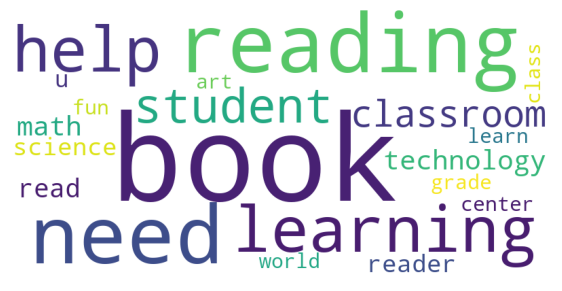

In [30]:
plt.subplots(figsize=(7,7),dpi=100)

wc = WordCloud(background_color='white',max_words=20,scale=2).generate_from_frequencies(fd1)

plt.imshow(wc)
plt.axis('off')
plt.show();

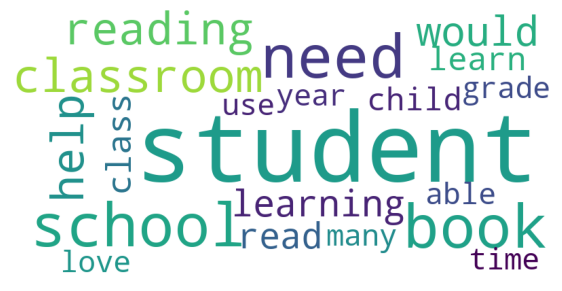

In [31]:
plt.subplots(figsize=(7,7),dpi=100)

wc = WordCloud(background_color='white',max_words=20,scale=2).generate_from_frequencies(fd2)

plt.imshow(wc)
plt.axis('off')
plt.show();

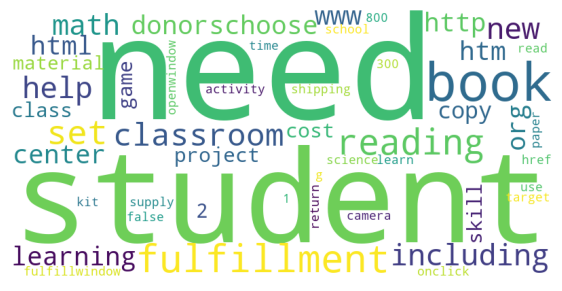

In [32]:
plt.subplots(figsize=(7,7),dpi=100)

wc = WordCloud(background_color='white',max_words=50,scale=2).generate_from_frequencies(fd3)

plt.imshow(wc)
plt.axis('off')
plt.show();

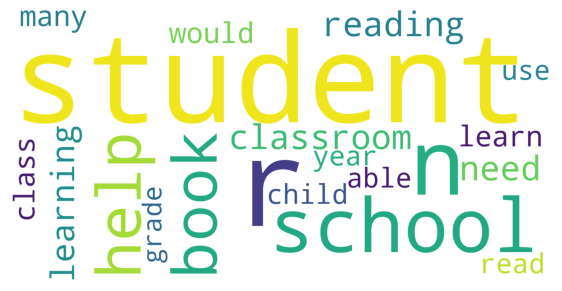

In [33]:
plt.subplots(figsize=(7,7),dpi=100)

wc = WordCloud(background_color='white',max_words=20,scale=4).generate_from_frequencies(fd4)

plt.imshow(wc)
plt.axis('off')
plt.show();

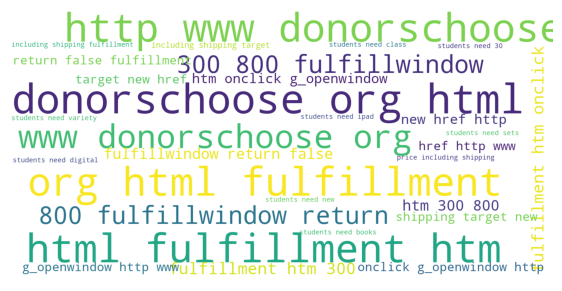

In [34]:
cv = CountVectorizer(essays['need_statement'].tolist(),stop_words = 'english',max_features = 100,ngram_range=(3,3))
x = cv.fit_transform(essays['need_statement'].tolist())

x.toarray().shape

cols = cv.get_feature_names()

#DTM
dtm = pd.DataFrame(x.toarray(),columns=cols)

fd3 = dtm.sum().to_dict()

plt.subplots(figsize=(7,7),dpi=100)

wc = WordCloud(background_color='white',max_words=30,scale=4).generate_from_frequencies(fd3)

plt.imshow(wc)
plt.axis('off')
plt.show();

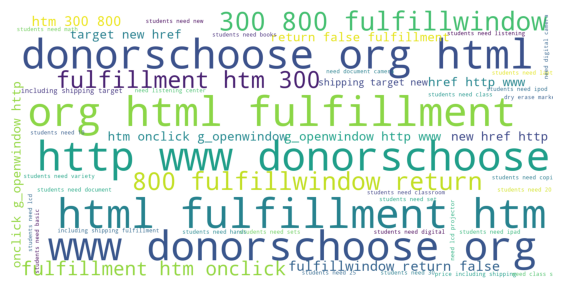

In [35]:
plt.subplots(figsize=(7,7),dpi=100)
wc = WordCloud(background_color='white',max_words=50,scale=4).generate_from_frequencies(fd3)
plt.imshow(wc)
plt.axis('off')
plt.show();

In [38]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

### Spliting data into train test

In [39]:
train1,test1=train_test_split(essays["title"].sample(n=60000),test_size=0.2,random_state=1)
train2,test2=train_test_split(essays["short_description"].sample(n=60000),test_size=0.2,random_state=1)
train3,test3=train_test_split(essays["need_statement"].sample(n=60000),test_size=0.2,random_state=1)
train4,test4=train_test_split(essays["essay"].sample(n=60000),test_size=0.2,random_state=1)

In [40]:
train1=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in train1]
test1=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in test1]

train2=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in train2]
test2=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in test2]

train3=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in train3]
test3=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in test3]

train4=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in train4]
test4=[re.sub(r'[^a-zA-z0-9]',' ',i) for i in test4]

### Making class for Lemma Tokenizer

In [41]:
# tokenizing and LEmatizing by defining a class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [42]:
tfidf1=TfidfVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_tfidf1=tfidf1.fit_transform(train1)

In [43]:
tfidf2=TfidfVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_tfidf2=tfidf2.fit_transform(train2)

In [44]:
tfidf3=TfidfVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_tfidf3=tfidf3.fit_transform(train3)

In [45]:
tfidf4=TfidfVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_tfidf4=tfidf4.fit_transform(train4)

In [46]:
# for plotting topic 
cv1=CountVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_cv1=cv1.fit_transform(train1)

In [47]:
# for plotting topic 
cv2=CountVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_cv2=cv2.fit_transform(train2)

In [48]:
# for plotting topic 
cv3=CountVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_cv3=cv3.fit_transform(train3)

In [49]:
# for plotting topic 
cv4=CountVectorizer(max_features=500,stop_words=stop_words,ngram_range=(1,1),tokenizer=LemmaTokenizer(),max_df=0.8)
tr_cv4=cv4.fit_transform(train4)

### Topic Modeling

In [50]:
lda1=LatentDirichletAllocation(n_components=5)
dt1=lda1.fit_transform(tr_tfidf1) # document topic distribution

In [51]:
lda2=LatentDirichletAllocation(n_components=5)
dt2=lda2.fit_transform(tr_tfidf2) # document topic distribution

In [52]:
lda3=LatentDirichletAllocation(n_components=5)
dt3=lda3.fit_transform(tr_tfidf3) # document topic distribution

In [53]:
lda4=LatentDirichletAllocation(n_components=5)
dt4=lda4.fit_transform(tr_tfidf4) # document topic distribution

In [54]:
tw1 = lda1.components_
tw1.shape

(5, 500)

In [55]:
tw2 = lda2.components_
tw2.shape

(5, 500)

In [56]:
tw3 = lda3.components_
tw3.shape

(5, 500)

In [57]:
tw4 = lda4.components_
tw4.shape

(5, 500)

In [58]:
type(tw4)

numpy.ndarray

In [59]:
def topic_words(h,n):
    index = h.argsort()[-n::][::-1]
    return np.array(tfidf1.get_feature_names())[index]

topic_words(tw1[0],n=10)

array(['read', 'science', 'help', 'kindergarten', 'let', 'get',
       'literacy', 'u', 'need', 'please'], dtype='<U14')

In [60]:
test_tfidf = tfidf1.transform(test1)
test_tfidf.shape

(12000, 500)

In [61]:
topic_words(tw1[0],n=10)

array(['read', 'science', 'help', 'kindergarten', 'let', 'get',
       'literacy', 'u', 'need', 'please'], dtype='<U14')

In [62]:
topic_words(tw2[0],n=10)

array(['station', 'series', 'would', 'urban', 'learning', 'hp', 'mind',
       'cd', 'action', 'cool'], dtype='<U14')

In [68]:
topic_words(tw3[0],n=10)

array(['growing', 'year', 'essential', 'old', 'interest', 'instrument',
       'interactive', 'eager', 'ipod', 'talk'], dtype='<U14')

In [69]:
topic_words(tw4[0],n=10)

array(['money', 'mathematics', 'leveled', 'club', 'hungry', 'green',
       'show', 'moving', 'comfy', 'let'], dtype='<U14')

In [63]:
def t(tw):
    for i in range(len(tw)):
        print(topic_words(tw[i],n=10))

In [64]:
t(tw1)

['read' 'science' 'help' 'kindergarten' 'let' 'get' 'literacy' 'u' 'need'
 'please']
['learning' 'center' 'listening' 'part' 'reader' 'music' 'project' '2'
 'hear' 'computer']
['technology' 'classroom' 'world' 'art' 'supply' 'student' 'library'
 'school' 'future' 'need']
['book' 'math' 'time' 'grade' 'kid' 'learn' 'ipad' 'making' 'see' 'first']
['reading' 'fun' 'make' 'success' 'writing' 'math' 'listen' 'game'
 'history' 'creating']


In [65]:
t(tw2)

['station' 'series' 'would' 'urban' 'learning' 'hp' 'mind' 'cd' 'action'
 'cool']
['station' 'mind' 'awesome' 'struggling' 'marker' 'hp' 'many' 'save'
 'savvy' 'number']
['save' 'station' 'tablet' 'mania' 'hungry' 'comfy' 'supply' 'machine'
 'color' 'mind']
['bully' 'reaching' 'r' 'station' 'hand' 'leveled' 'low' 'save' 'reach'
 'year']
['station' 'really' 'leaping' 'worth' 'wanted' 'color' 'tell' 'life'
 'classroom' 'difference']


In [66]:
t(tw3)

['growing' 'year' 'essential' 'old' 'interest' 'instrument' 'interactive'
 'eager' 'ipod' 'talk']
['mathematics' 'improving' 'say' 'small' 'happy' 'mathematician' 'ilearn'
 'awesome' 'listen' 'recess']
['cool' 'connection' 'love' 'seeing' 'printer' 'character' 'plant'
 'hunger' 'imagination' 'child']
['child' 'recess' 'creativity' 'real' 'perfect' 'living' 'savvy' 'eager'
 'seeing' 'paint']
['color' 'know' 'dream' 'projecting' 'environmental' 'area' 'art' 'team'
 'creativity' 'esl']


In [67]:
t(tw4)

['money' 'mathematics' 'leveled' 'club' 'hungry' 'green' 'show' 'moving'
 'comfy' 'let']
['science' 'challenge' 'would' 'leveled' 'fit' 'come' 'project' 'write'
 'hungry' 'let']
['talk' 'count' 'kindergartener' 'comfy' 'using' 'leveled' 'alive' 'write'
 'projecting' 'learner']
['becoming' 'style' 'hungry' 'organization' 'moving' 'world' 'year'
 'writing' 'part' 'come']
['calculator' 'recess' 'real' 'really' 'listen' 'like' 'magic' 'station'
 'hungry' 'comfy']


### Model Building

In [70]:
projects=pd.read_csv('data_projects.csv')
outcomes=pd.read_csv('data_outcomes.csv')
essays=pd.read_csv('data_essays.csv')

In [71]:
print(projects.shape)
print(outcomes.shape)
print(essays.shape)

(664098, 35)
(619326, 12)
(664098, 6)


In [72]:
projects

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,...,Books,highest poverty,Grades 6-8,30.0,555.81,653.89,32.0,f,f,2014-05-12
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,...,Books,highest poverty,Grades PreK-2,30.0,296.47,348.79,22.0,f,f,2014-05-12
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,...,Technology,high poverty,Grades PreK-2,30.0,430.89,506.93,17.0,f,f,2014-05-11
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,...,Books,highest poverty,Grades 3-5,30.0,576.07,677.73,12.0,f,f,2014-05-11
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,...,Other,highest poverty,Grades PreK-2,30.0,408.40,480.47,24.0,f,f,2014-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664093,a7236ea96c812895cafc5d700d779147,c4f90a541cb81e68cd7ad180309985ae,a1e14d253e77ffccc074705527845b4a,3.600081e+11,40.809677,-73.939178,New York,NY,10037.0,urban,...,Supplies,highest poverty,Grades PreK-2,NaN,231.00,281.71,0.0,f,f,2002-09-17
664094,e02da37beb332eb66c2d2ba989c597ad,d95c94eea994274d614be50bddd89973,bbd70e92262f0f0a342df5d1f3119d8e,3.600097e+11,40.701778,-74.011840,New York,NY,10004.0,urban,...,Technology,highest poverty,Grades 9-12,NaN,1129.00,1376.83,0.0,f,f,2002-09-17
664095,82e536f14eadf2671a70e03416f695a3,b00d2790934ce7487c99bc9d6e1d5d4d,0c5b1a4b6985dcd42c72b732c774474c,3.600077e+11,40.770233,-73.950760,New York,NY,10075.0,urban,...,Supplies,moderate poverty,Grades 3-5,NaN,125.00,152.44,0.0,f,f,2002-09-16
664096,e139df754a873a62d93daa56acbf8040,e5476c2ef97b33614445a17554535adc,a81c26262a3ad70702a8f14e5329b023,3.600077e+11,40.765517,-73.960090,New York,NY,10065.0,NaN,...,Books,highest poverty,Grades 9-12,NaN,125.00,152.44,0.0,f,f,2002-09-13


In [73]:
projects.isnull().sum()/projects.shape[0]*100

projectid                                  0.000000
teacher_acctid                             0.000000
schoolid                                   0.000000
school_ncesid                              6.435195
school_latitude                            0.000000
school_longitude                           0.000000
school_city                                0.000000
school_state                               0.000000
school_zip                                 0.000602
school_metro                              12.333722
school_district                            0.142750
school_county                              0.002560
school_charter                             0.000000
school_magnet                              0.000000
school_year_round                          0.000000
school_nlns                                0.000000
school_kipp                                0.000000
school_charter_ready_promise               0.000000
teacher_prefix                             0.000602
teacher_teac

In [74]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664098 entries, 0 to 664097
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   projectid                               664098 non-null  object 
 1   teacher_acctid                          664098 non-null  object 
 2   schoolid                                664098 non-null  object 
 3   school_ncesid                           621362 non-null  float64
 4   school_latitude                         664098 non-null  float64
 5   school_longitude                        664098 non-null  float64
 6   school_city                             664098 non-null  object 
 7   school_state                            664098 non-null  object 
 8   school_zip                              664094 non-null  float64
 9   school_metro                            582190 non-null  object 
 10  school_district                         6631

## Filling Null values

In [75]:
projects['school_ncesid'].fillna(projects['school_ncesid'].mean(), inplace = True)
projects['school_metro'].fillna(projects['school_metro'].mode()[0], inplace = True)
projects['school_district'].fillna(projects['school_district'].mode()[0], inplace = True)
projects['school_zip'].fillna(projects['school_zip'].mode()[0], inplace = True)
projects['school_county'].fillna(projects['school_county'].mode()[0], inplace = True)
projects['teacher_prefix'].fillna(projects['teacher_prefix'].mode()[0], inplace = True)
projects['primary_focus_subject'].fillna(projects['primary_focus_subject'].mode()[0], inplace = True)
projects['primary_focus_area'].fillna(projects['primary_focus_area'].mode()[0], inplace = True)
projects['secondary_focus_subject'].fillna(projects['secondary_focus_subject'].mode()[0], inplace = True)
projects['secondary_focus_area'].fillna(projects['secondary_focus_area'].mode()[0], inplace = True)
projects['resource_type'].fillna(projects['resource_type'].mode()[0], inplace = True)
projects['fulfillment_labor_materials'].fillna(projects['fulfillment_labor_materials'].mode()[0], inplace = True)
projects['grade_level'].fillna(projects['grade_level'].mode()[0], inplace = True)
projects['fulfillment_labor_materials'].fillna(projects['fulfillment_labor_materials'].mode()[0], inplace = True)
projects['students_reached'].fillna(projects['students_reached'].mean(), inplace = True)

In [76]:
outcomes

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
1,ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
2,ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
3,ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
4,ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
619321,0000ee613c92ddc5298bf63142996a5c,f,t,t,t,f,t,t,f,0.0,2.0,4.0
619322,0000b38bbc7252972f7984848cf58098,f,f,t,t,f,f,t,f,50.0,0.0,2.0
619323,00002d691c05c51a5fdfbb2baef0ba25,f,f,f,f,t,t,f,f,100.0,0.0,5.0
619324,00002bff514104264a6b798356fdd893,f,f,t,t,f,f,t,f,50.0,0.0,2.0


In [77]:
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619326 entries, 0 to 619325
Data columns (total 12 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   projectid                                       619326 non-null  object 
 1   is_exciting                                     619326 non-null  object 
 2   at_least_1_teacher_referred_donor               524928 non-null  object 
 3   fully_funded                                    619326 non-null  object 
 4   at_least_1_green_donation                       524928 non-null  object 
 5   great_chat                                      619326 non-null  object 
 6   three_or_more_non_teacher_referred_donors       524928 non-null  object 
 7   one_non_teacher_referred_donor_giving_100_plus  524928 non-null  object 
 8   donation_from_thoughtful_donor                  524928 non-null  object 
 9   great_messages_proportion 

In [78]:
outcomes.isnull().sum()/outcomes.shape[0]*100

projectid                                          0.000000
is_exciting                                        0.000000
at_least_1_teacher_referred_donor                 15.242053
fully_funded                                       0.000000
at_least_1_green_donation                         15.242053
great_chat                                         0.000000
three_or_more_non_teacher_referred_donors         15.242053
one_non_teacher_referred_donor_giving_100_plus    15.242053
donation_from_thoughtful_donor                    15.242053
great_messages_proportion                         29.037857
teacher_referred_count                            15.242053
non_teacher_referred_count                        15.242053
dtype: float64

In [79]:
outcomes['at_least_1_teacher_referred_donor'].fillna(outcomes['at_least_1_teacher_referred_donor'].mode()[0], inplace = True)
outcomes['at_least_1_green_donation'].fillna(outcomes['at_least_1_green_donation'].mode()[0], inplace = True)
outcomes['three_or_more_non_teacher_referred_donors'].fillna(outcomes['three_or_more_non_teacher_referred_donors'].mode()[0], inplace = True)
outcomes['one_non_teacher_referred_donor_giving_100_plus'].fillna(outcomes['one_non_teacher_referred_donor_giving_100_plus'].mode()[0], inplace = True)
outcomes['donation_from_thoughtful_donor'].fillna(outcomes['donation_from_thoughtful_donor'].mode()[0], inplace = True)
outcomes['great_messages_proportion'].fillna(outcomes['great_messages_proportion'].mean(), inplace = True)
outcomes['teacher_referred_count'].fillna(outcomes['teacher_referred_count'].mean(), inplace = True)
outcomes['non_teacher_referred_count'].fillna(outcomes['non_teacher_referred_count'].mean(), inplace = True)

In [80]:
essays

,projectid,teacher_acctid,title,short_description,need_statement,essay
0,ffffc4f85b60efc5b52347df489d0238,c24011b20fc161ed02248e85beb59a90,iMath,It is imperative that teachers bring technolog...,My students need four iPods.,I am a fourth year fifth grade math teacher. T...
1,ffffac55ee02a49d1abc87ba6fc61135,947066d0af47e0566f334566553dd6a6,Recording Rockin' Readers,Can you imagine having to translate everything...,My students need a camcorder.,Can you imagine having to translate everything...
2,ffff97ed93720407d70a2787475932b0,462270f5d5c212162fcab11afa2623cb,Kindergarten In Need of Important Materials!,It takes a special person to donate to a group...,My students need 17 assorted classroom materia...,Hi. I teach a wonderful group of 4-5 year old ...
3,ffff7266778f71242675416e600b94e1,b9a8f14199e0d8109200ece179281f4f,Let's Find Out!,My Kindergarten students come from a variety o...,"My students need 25 copies of Scholastic's ""Le...",My Kindergarten students come from a variety o...
4,ffff418bb42fad24347527ad96100f81,e885fb002a1d0d39aaed9d21a7683549,Whistle While We Work!,"By using the cross curricular games requested,...",My students need grade level appropriate games...,All work and no play makes school a dull place...
...,...,...,...,...,...,...
664093,0000ee613c92ddc5298bf63142996a5c,e0c0a0214d3c2cfdc0ab6639bc3c5342,Technology Upgrade A Must-Kindergartners Ready!,Kindergarten is an exciting time for learning ...,My students need an iPad mini to support instr...,Kindergarten is an exciting time for learning ...
664094,0000b38bbc7252972f7984848cf58098,e1aa1ae5301d0cda860c4d9c89c24919,Visual Display Technology in the Classroom,My students have very limited exposure to tech...,My students need access to a projector in the ...,My students have very limited exposure to tech...
664095,00002d691c05c51a5fdfbb2baef0ba25,7ad6abc974dd8b62773f79f6cbed48d5,You Go Read at HRS,"My students need high quality books, such as W...","My students need high quality books, such as W...",Our students need the challenge to read high q...
664096,00002bff514104264a6b798356fdd893,3414541eb63108700b188648f866f483,Speedy Shark Reading Club,My students need more incentives to make them ...,My students need word building centers 20 At-Y...,My students need more incentives to make them ...


In [81]:
essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664098 entries, 0 to 664097
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   projectid          664098 non-null  object
 1   teacher_acctid     664098 non-null  object
 2   title              664081 non-null  object
 3   short_description  663966 non-null  object
 4   need_statement     662626 non-null  object
 5   essay              664095 non-null  object
dtypes: object(6)
memory usage: 30.4+ MB


In [82]:
essays.isnull().sum()/essays.shape[0]*100

projectid            0.000000
teacher_acctid       0.000000
title                0.002560
short_description    0.019877
need_statement       0.221654
essay                0.000452
dtype: float64

In [83]:
essays['title'].fillna(essays['title'].mode()[0], inplace = True)
essays['short_description'].fillna(essays['short_description'].mode()[0], inplace = True)
essays['need_statement'].fillna(essays['need_statement'].mode()[0], inplace = True)
essays['essay'].fillna(essays['essay'].mode()[0], inplace = True)

### Merging the 3 datasets into 1

In [84]:
merge = pd.merge(pd.merge(projects, outcomes, how = 'outer'), essays, how = 'outer')

In [85]:
merge.isna().sum()/merge.shape[0]*100

projectid                                         0.000000
teacher_acctid                                    0.000000
schoolid                                          0.000000
school_ncesid                                     0.000000
school_latitude                                   0.000000
school_longitude                                  0.000000
school_city                                       0.000000
school_state                                      0.000000
school_zip                                        0.000000
school_metro                                      0.000000
school_district                                   0.000000
school_county                                     0.000000
school_charter                                    0.000000
school_magnet                                     0.000000
school_year_round                                 0.000000
school_nlns                                       0.000000
school_kipp                                       0.0000

In [86]:
merge.shape

(664098, 50)

In [87]:
audit = merge.describe(include = 'all').T
audit

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
projectid,664098,664098,bb937ae7f897a1497278993af35ca793,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teacher_acctid,664098,249555,787720cc575e3204991b8ca18d312d2b,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolid,664098,57004,9231edfbd3aa42675e70e69aea8b0a36,944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_ncesid,664098.0,NaN,NaN,NaN,260857694688.343597,153775136833.688416,10000500870.0,120039000509.0,260857694688.358582,370297001274.0,610000900044.0
school_latitude,664098.0,NaN,NaN,NaN,37.240948,4.668155,18.24914,34.038082,37.662476,40.758827,67.258157
school_longitude,664098.0,NaN,NaN,NaN,-93.34476,17.761908,-176.634989,-112.003214,-87.681219,-79.193091,-66.628036
school_city,664098,9007,Chicago,28435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_state,664098,52,CA,126242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_zip,664098.0,NaN,NaN,NaN,52926.196835,31193.818856,410.0,27589.0,50702.0,85043.0,99950.0
school_metro,664098,3,urban,431611,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
merge['is_exciting'].fillna(merge['is_exciting'].mode()[0], inplace = True)
merge['at_least_1_teacher_referred_donor'].fillna(merge['at_least_1_teacher_referred_donor'].mode()[0], inplace = True)
merge['fully_funded'].fillna(merge['fully_funded'].mode()[0], inplace = True)
merge['at_least_1_green_donation'].fillna(merge['at_least_1_green_donation'].mode()[0], inplace = True)
merge['great_chat'].fillna(merge['great_chat'].mode()[0], inplace = True)
merge['three_or_more_non_teacher_referred_donors'].fillna(merge['three_or_more_non_teacher_referred_donors'].mode()[0], inplace = True)
merge['one_non_teacher_referred_donor_giving_100_plus'].fillna(merge['one_non_teacher_referred_donor_giving_100_plus'].mode()[0], inplace = True)
merge['donation_from_thoughtful_donor'].fillna(merge['donation_from_thoughtful_donor'].mode()[0], inplace = True)
merge['great_messages_proportion'].fillna(merge['great_messages_proportion'].median(), inplace = True)
merge['teacher_referred_count'].fillna(merge['teacher_referred_count'].median(), inplace = True)
merge['non_teacher_referred_count'].fillna(merge['non_teacher_referred_count'].median(), inplace = True)


In [89]:
merge.shape

(664098, 50)

In [90]:
merge.isna().sum()/merge.shape[0]*100

projectid                                         0.0
teacher_acctid                                    0.0
schoolid                                          0.0
school_ncesid                                     0.0
school_latitude                                   0.0
school_longitude                                  0.0
school_city                                       0.0
school_state                                      0.0
school_zip                                        0.0
school_metro                                      0.0
school_district                                   0.0
school_county                                     0.0
school_charter                                    0.0
school_magnet                                     0.0
school_year_round                                 0.0
school_nlns                                       0.0
school_kipp                                       0.0
school_charter_ready_promise                      0.0
teacher_prefix              

In [91]:
merge.date_posted.max()

'2014-05-12'

## Labeling Target Variable

In [92]:
def bins(x):
    if x=="f":
        return 0
    else:
        return 1

In [93]:
merge['is_exciting']=merge['is_exciting'].map(bins)

In [94]:
merge.drop('projectid', inplace = True, axis=1)
merge.drop('teacher_acctid', inplace = True, axis=1)
merge.drop('schoolid', inplace = True, axis=1)
merge.drop('school_ncesid', inplace = True, axis=1)
merge.drop('title', inplace = True, axis=1)
merge.drop('short_description', inplace = True, axis=1)
merge.drop('need_statement', inplace = True, axis=1)
merge.drop('essay', inplace = True, axis=1)
merge.drop('school_state', inplace = True, axis=1)
merge.drop('school_district', inplace = True, axis=1)
merge.drop('school_county', inplace = True, axis=1)

In [95]:
merge['date_posted'] = pd.to_datetime(merge['date_posted'])

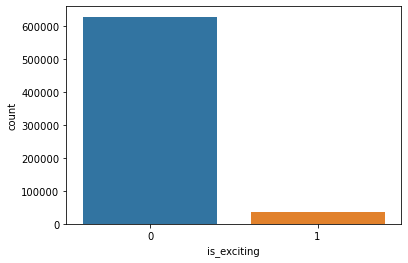

In [96]:
sns.countplot(merge['is_exciting']);

As we can see here that the data is **highly imbalanced**. It consist of approx **95(94.47)%** 0 or False values

In [97]:
merge['is_exciting'].value_counts()

0    627388
1     36710
Name: is_exciting, dtype: int64

In [98]:
merge = pd.get_dummies(merge, drop_first = True)

### I am using test data from 2013-01-01 because if we use 2014-01-01 we get data for only one class which shows 100% accuracy of model and model may not perform well on the other class thats not good for testing so i am taking test data from date 2013-01-01.

In [99]:
test_data = merge[merge['date_posted'] > '2013-01-01']

In [100]:
train_data = merge[(merge['date_posted'] < '2013-01-01') &( merge['date_posted'] > '2008-01-01') ]

### Taking Only sample data. Because if we try for whole data set it will give memory error

In [101]:
train_data = train_data.sample(60000)

In [102]:
train_data.shape

(60000, 9116)

In [103]:
test_data = test_data.sample(15000)

In [104]:
test_data.shape

(15000, 9116)

In [105]:
train_data.drop('date_posted', inplace = True, axis = 1)

In [106]:
test_data.drop('date_posted', inplace = True, axis = 1)

### Getting x_train, x_test, y_train,y_test

In [107]:
x_train = train_data.drop('is_exciting', axis = 1).values

In [108]:
y_train = train_data[['is_exciting']]


In [109]:
x_test = test_data.drop('is_exciting', axis = 1).values


In [110]:
y_test = test_data[['is_exciting']]

### UpSampling the data

In [111]:
from imblearn.over_sampling import SMOTE

In [112]:
smt = SMOTE()

In [113]:
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

In [114]:
y_train_sm.value_counts()

is_exciting
0              56825
1              56825
dtype: int64

### Scaling the data

In [115]:
from sklearn.preprocessing import StandardScaler

In [116]:
scalar=StandardScaler()

In [117]:
x_train_enc = scalar.fit_transform(x_train_sm)

In [118]:
x_test_enc = scalar.fit_transform(x_test)

### Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
log_reg = LogisticRegression(max_iter=80,solver='newton-cg')

In [121]:
log_reg.fit(x_train_enc,y_train_sm)

LogisticRegression(max_iter=80, solver='newton-cg')

In [122]:
y_pred=log_reg.predict(x_test_enc)

In [123]:
from sklearn import metrics

In [124]:
def confusion_matrix(actual,predicted):
    cm=metrics.confusion_matrix(actual, predicted,[1,0])
    sns.heatmap(cm,annot=True,fmt='.2f',xticklabels=['is exited','is not exited'],yticklabels=['is exited','is not exited'])
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted Labels')

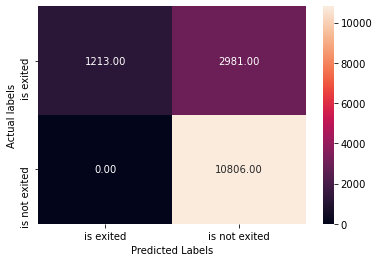

In [125]:
confusion_matrix(y_pred, y_test)

In [126]:
from sklearn.metrics import classification_report

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88     13787
           1       0.29      1.00      0.45      1213

    accuracy                           0.80     15000
   macro avg       0.64      0.89      0.66     15000
weighted avg       0.94      0.80      0.84     15000



As we can see here logistic regression is showing **80%** accuracy.

### Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier 
rnd_clf = RandomForestClassifier()
rnd_clf.fit(x_train_enc,y_train_sm)

RandomForestClassifier()

In [129]:
pred = rnd_clf.predict(x_test_enc) 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.49      0.65     13787
           1       0.15      1.00      0.25      1213

    accuracy                           0.53     15000
   macro avg       0.57      0.74      0.45     15000
weighted avg       0.93      0.53      0.62     15000



Random Forest is showing **53%** accuracy only

### Gird Search cv

In [ ]:
from sklearn.model_selection import GridSearchCV 
tuned_params = [{'n_estimators': range(10,20), 
                  'max_depth': range(3,10),
                  'max_features':['sqrt','log2']

}]

clf = GridSearchCV(RandomForestClassifier(), tuned_params,cv=5, scoring='accuracy', verbose=17, n_jobs=-1) 

clf.fit(x_train_enc,y_train_sm)

### Grid search cannot be performed here because it shows memory error everytime